<a href="https://colab.research.google.com/github/AramMohammed1/ResumeClassifactionNLP/blob/Synset_Aram/SynsetWithBestResult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Resume Classification NLP**

## Importing Libraries and Setting Up Environment


In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#VPN Needed
nltk.download("stopwords")
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from nltk import word_tokenize
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.tokenize import sent_tokenize, word_tokenize
!pip install stanza
import stanza
from sklearn.model_selection import GridSearchCV
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from nltk import ngrams






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Original data

### Loading and Preparing the Dataset



In [169]:
df = pd.read_csv('/content/drive/MyDrive/Resume.csv')

df = df.drop(['ID','Resume_html'],axis=1)
df = df.rename(columns={'Resume_str': 'Resume'})

df.head()


,Resume,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


###  Preprocessing Data

removing URls, hashtags, mentions and others

In [170]:

def preprocess(txt):
    sentences = nltk.tokenize.sent_tokenize(txt)

    # Step 2: Process each sentence individually and tokenize
    tokenized_sentences = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = re.sub('http\S+\s*', ' ', sentence)  # Remove URLs
        sentence = re.sub('RT|cc', ' ', sentence)  # Remove "RT" and "cc"
        sentence = re.sub('#\S+', '', sentence)  # Remove hashtags
        sentence = re.sub('@\S+', ' ', sentence)  # Remove mentions
        sentence = re.sub('\s+', ' ', sentence)  # Remove extra whitespace

        # Tokenize the cleaned sentence into words and add to list
        tokens = nltk.tokenize.word_tokenize(sentence)
        tokenized_sentences.append(tokens)

    return tokenized_sentences


In [171]:
nltk.download('punkt_tab')
df['Resume'] = df['Resume'].apply(lambda w: preprocess(w))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [172]:
df.head()

,Resume,Category
0,"[[hr, administrator, marketing, associate, hr,...",HR
1,"[[hr, specialist, us, hr, operations, summary,...",HR
2,"[[hr, director, summary, over, years, experien...",HR
3,"[[hr, specialist, summary, dedicated, driven, ...",HR
4,"[[hr, manager, skill, highlights, hr, skills, ...",HR



## NLTK Pos Tagging

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

def pos_tag_sentences(tokenized_sentences):
    pos_tagged_sentences = []
    for tokens in tokenized_sentences:
        # Perform POS tagging on the tokenized sentence
        pos_tags = nltk.pos_tag(tokens)
        # Add POS-tagged sentence to the list
        pos_tagged_sentences.append(pos_tags)

    return pos_tagged_sentences
dfPosTag = df.copy()
dfPosTag['Resume'] = dfPosTag['Resume'].apply(lambda w: pos_tag_sentences(w))



[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [131]:
dfPosTag.head()

,Resume,Category
0,"[[(hr, NN), (administrator, NN), (marketing, N...",HR
1,"[[(hr, NN), (specialist, NN), (us, PRP), (hr, ...",HR
2,"[[(hr, NNS), (director, NN), (summary, VBP), (...",HR
3,"[[(hr, JJ), (specialist, NN), (summary, NN), (...",HR
4,"[[(hr, NN), (manager, NN), (skill, VB), (highl...",HR


### Nouns Extraction

In [163]:
def extract_nouns(pos_tagged_sentences):
    nouns_sentences = []
    for sentence in pos_tagged_sentences:
        # Extract nouns based on POS tags
        nouns = [word for word, pos in sentence if pos.startswith('NN')]  # 'NN' indicates noun types
        nouns_sentences.append(nouns)

    return nouns_sentences
dfNounsOnly = dfPosTag.copy()
dfNounsOnly['Resume'] = dfNounsOnly['Resume'].apply(lambda w: extract_nouns(w))
dfNounsOnly.head()

,Resume,Category
0,"[[hr, administrator, marketing, hr, administra...",HR
1,"[[hr, specialist, operations, media, backgroun...",HR
2,"[[hr, director, years, years, resources, manag...",HR
3,"[[specialist, summary, years, customer, servic...",HR
4,"[[hr, manager, highlights, skills, department,...",HR


## SnowBall Stemmer


In [164]:
def stem_nouns(nouns_sentences):
    stemmer = SnowballStemmer(language='english')
    stemmed_sentences = []
    for nouns in nouns_sentences:
        stemmed_nouns = [stemmer.stem(noun) for noun in nouns]
        stemmed_sentences.append(' '.join(stemmed_nouns))

    return ' '.join(stemmed_sentences)

dfNounsOnly['Resume'] = dfNounsOnly['Resume'].apply(lambda w: stem_nouns(w))

dfNounsOnly['Resume'][0]


'hr administr market hr administr summari custom servic manag year experi hospit custom servic manag builder leader custom team strive commit custom servic highlight custom satisfact team manag market savvi conflict resolut techniqu develop multi tasker client relat omplish dot supervisor train certif ihg custom loyalti market segment hilton manag train certif trainer cross server hospit system hilton micro fidelio opera reserv system or cours seminar custom servic sale inventori control loss prevent safeti time manag leadership perform assess experi hr administr market hr administr dec compani name citi state polici direct activ employ compens labor relat benefit train employe servic prepar employe separ notic document record benefit plan insur pension plan personnel transact hire promot transfer perform review termin employe statist govern report advis manag resolut employe relat issu administ benefit program life health insur pension plan absenc employe assist market associ market c

### Merging Sentences

In [182]:
def joinFun(stentencesList):
    joinedSentence = []
    for sentence in stentencesList:
        words = [word for word in sentence]
        joinedSentence.append(' '.join(words))

    return ' '.join(joinedSentence)

df['Resume'] = df['Resume'].apply(lambda w: joinFun(w))

df['Resume'][0]

'hr administrator marketing associate hr administrator summary dedicated customer service manager with years of experience in hospitality and customer service management respected builder and leader of customer focused teams strives to instill a shared enthusiastic commitment to customer service highlights focused on customer satisfaction team management marketing savvy conflict resolution techniques training and development skilled multi tasker client relations specialist a omplishments missouri dot supervisor training certification certified by ihg in customer loyalty and marketing by segment hilton worldwide general manager training certification a omplished trainer for cross server hospitality systems such as hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses and seminars in customer service sales strategies inventory control loss prevention safety time management leadership and performance assessment experience hr administrator marketing ass

## Stanza Dependency Tree

In [ ]:

# nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

# def process_sentences(sentences):
#     results = []
#     doc = nlp(sentences)
#     for sent in doc.sentences:
#         for word in sent.words:
#                 head_word = sent.words[word.head - 1].text if word.head > 0 else "root"
#                 word_info = {
#                     'id': word.id,
#                     'word': word.text,
#                     'head_id': word.head,
#                     'head': head_word,
#                     'deprel': word.deprel
#                 }
#                 results.append(word_info)
#     return results

# # Example usage
# for i in range(len(df['Resume'])):
#   df['Resume'][i] = process_sentences(df['Resume'][i])


In [ ]:
# df.to_csv('./Level_2_Dependency_Tree.csv', index=False)
# df.to_pickle('./Level_2_Dependency_Tree.pkl')
dfDEP = pd.read_pickle('/content/drive/MyDrive/NLP/Level_2_Dependency_Tree.pkl')


In [ ]:
dfDEP['Resume'][0]

### extract head headhead

In [ ]:
# Function to extract sequences from the 'Resume' column in the DataFrame
def extract_sequences_from_df(df):
    all_two_word_sequences = []
    all_three_word_sequences = []

    for _, row in df.iterrows():
        words = row['Resume']  # Get the list of dictionaries in the 'Resume' column
        data_lookup = {word['id']: word for word in words}  # Create a lookup by word ID

        two_word_sequences = []
        three_word_sequences = []

        for word in words:
            # Extract two-word sequence (word, head)
            if word['head_id'] in data_lookup:
                head_word = data_lookup[word['head_id']]['word']
                two_word_sequences.append((word['word'], head_word))

                # Extract three-word sequence (word, head, head's head)
                head_head_id = data_lookup[word['head_id']]['head_id']
                if head_head_id in data_lookup:
                    head_head_word = data_lookup[head_head_id]['word']
                    three_word_sequences.append((word['word'], head_word, head_head_word))

        # Add the extracted sequences to the lists
        all_two_word_sequences.append(two_word_sequences)
        all_three_word_sequences.append(three_word_sequences)

    # Add the sequences as new columns in the DataFrame
    return all_two_word_sequences,all_three_word_sequences

# Apply the function to the DataFrame
a,b= extract_sequences_from_df(df)
print(a)


### Merging

In [ ]:
def mergeDep(listDEP):
  mergedString=""
  for dep in listDEP:
    if dep['deprel']=='root' or dep['deprel']=='punct':
      continue
    mergedString+=dep['word']+"_"+dep['head']+"_"+dep['deprel']+" "
  return mergedString
dfDEP['Resume'] = dfDEP['Resume'].apply(lambda w: mergeDep(w))
dfDEP.head()

,Resume,Category
0,HR_ADMINISTRATOR_compound MARKETING_ASSOCIATE_...,HR
1,HR_SPECIALIST_compound US_OPERATIONS_compound ...,HR
2,HR_DIRECTOR_compound Summary_DIRECTOR_compound...,HR
3,HR_Summary_compound SPECIALIST_Summary_compoun...,HR
4,HR_MANAGER_compound Skill_Highlights_compound ...,HR


## Stanza Named Entity Recognition

In [ ]:

# nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')


# def er_process_sentences(sentences):
#     results = []
#     doc = nlp(sentences)
#     for sent in doc.sentences:
#         for ent in sent.ents:
#                 ent_info = {
#                     'word': ent.text,
#                     'type': ent.type
#                 }
#                 results.append(ent_info)
#     return results
# for i in range(len(df['Resume'])):
#   df['Resume'][i] = er_process_sentences(df['Resume'][i])


INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| ner       | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
<ipython-input-12-d948c9ee11c9>:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFra

In [ ]:
# df.to_csv('./Level_2_Named_Entity.csv', index=False)
# df.to_pickle('./Level_2_Named_Entity.pkl')
df_NER = pd.read_pickle('/content/drive/MyDrive/NLP/Level_2_Named_Entity.pkl')


In [ ]:
df_NER.head()

,Resume,Category
0,"[{'word': '15+ years', 'type': 'DATE'}, {'word...",HR
1,"[{'word': 'HR SPECIALIST', 'type': 'ORG'}, {'w...",HR
2,"[{'word': '20 years', 'type': 'DATE'}, {'word'...",HR
3,"[{'word': '20 years', 'type': 'DATE'}, {'word'...",HR
4,"[{'word': 'Three', 'type': 'CARDINAL'}, {'word...",HR


In [ ]:
def myMerge(listNER):
  mergedString=""
  for ner in listNER:
    ner_=""
    if ner['type']=="PERSON" or ner['type']=="DATE" or ner['type']=="CARDINAL":
      continue
    ner['word'] =  re.sub('\s+', '_', ner['word'])  # Remove extra whitespace

    mergedString+=ner['word']+" "
  return mergedString
df_NER['Resume'] = df_NER['Resume'].apply(lambda w: myMerge(w))
df_NER.head()

,Resume,Category
0,Hospitality_and_Customer_Service_Management Hi...,HR
1,HR_SPECIALIST US US Operations US RFI SharePoi...,HR
2,Human_Resources_Executive_Management SHRM Cham...,HR
3,Microsoft FMLA the_Absence_Management_Team San...,HR
4,Lawson Paychex Kronos ADP MS_Office VSTD VLTD ...,HR


In [ ]:
df_NER['Resume'][0]

'Hospitality_and_Customer_Service_Management Hilton_OnQ Micros_Opera_PMS Fidelio_OPERA_Reservation_System ORS Holidex_Completed Facebook Marketing_and_Advertising Chamber_of_Commerce Customer_Service Human_Resources second State_Education_N/A_,_Business_Administration Jefferson_College_－_City_,_State_Business_Administration_Marketing_/_Advertising_High_School_Diploma College_Prep. Jefferson_College_Skills_Accounting Customer_Service '

## Synset extraction

In [ ]:

df.head()


,Resume,Category
0,"[[hr, administrator, marketing, associate, hr,...",HR
1,"[[hr, specialist, us, hr, operations, summary,...",HR
2,"[[hr, director, summary, over, years, experien...",HR
3,"[[hr, specialist, summary, dedicated, driven, ...",HR
4,"[[hr, manager, skill, highlights, hr, skills, ...",HR


In [132]:

def get_wordnet_pos(tag):
    if tag.startswith('NN'):  # Noun
        return wordnet.NOUN
    elif tag.startswith('VB'):  # Verb
        return wordnet.VERB
    elif tag.startswith('JJ'):  # Adjective
        return wordnet.ADJ
    elif tag.startswith('RB'):  # Adverb
        return wordnet.ADV
    else:  # If no match, return None
        return None
def SysnsetExtractionPos(sentences):
  ret = ""
  for sentnce in sentences:
    result = ""
    for word in sentnce:
      syns =  wordnet.synsets(word[0],pos=get_wordnet_pos(word[1]))
      for syn in syns:
        result +=" "+ syn.name()
    ret += result
    return ret


In [173]:
def SysnsetExtraction(sentences):
  ret = ""
  for sentnce in sentences:
    result = ""
    for word in sentnce:
      syns =  wordnet.synsets(word)
      for syn in syns:
        result +=" "+ syn.name()
    ret += result
    return ret

In [149]:
dfSynsetPos = dfPosTag.copy()
dfSynsetPos['Resume'] = dfSynsetPos['Resume'].apply(lambda w: SysnsetExtractionPos(w))


In [177]:
dfSynset = df.copy()
dfSynset['Resume'] = dfSynset['Resume'].apply(lambda w: SysnsetExtraction(w))


In [178]:
dfSynset.head()

,Resume,Category
0,hour.n.01 administrator.n.01 administrator.n....,HR
1,hour.n.01 specialist.n.01 specialist.n.02 uni...,HR
2,hour.n.01 director.n.01 director.n.02 directo...,HR
3,hour.n.01 specialist.n.01 specialist.n.02 sum...,HR
4,hour.n.01 director.n.01 coach.n.01 skill.n.01...,HR


In [ ]:
syn = wordnet.synsets('market')[0]
print ("Synset :  ", syn.definition())


Synset :   the world of commercial activity where goods and services are bought and sold


## Tfidf and features selection

In [ ]:
df = pd.read_pickle('./exported.pkl')


In [142]:
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from scipy.sparse import hstack
# from sklearn.feature_selection import SelectKBest, chi2

# requiredText = df['Resume'].values
# requiredTarget = df['Category'].values

# # word_vectorizer = TfidfVectorizer(
# #     sublinear_tf=True,
# #     stop_words='english')
# # word_vectorizer.fit(requiredText)
# # WordFeatures = word_vectorizer.transform(requiredText)

# word_vectorizer = TfidfVectorizer(
#     sublinear_tf=True,
#     stop_words='english',
#     min_df=0.01,  # Exclude terms in <1% of documents
#     max_df=0.7,    # Exclude terms in >70% of documents
#     ngram_range=(1, 3)
#     )
# word_vectorizer.fit(requiredText)
# WordFeatures = word_vectorizer.transform(requiredText)

# chi2_selector = SelectKBest(chi2, k=250)
# WordFeatures = chi2_selector.fit_transform(WordFeatures, requiredTarget)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# TF-IDF and feature selection for the first data frame (df)
# requiredText = df['Resume'].values
# requiredTarget = df['Category'].values

# word_vectorizer_df = TfidfVectorizer(
#     sublinear_tf=True,
#     stop_words='english',
#     min_df=0.01,  # Exclude terms in <1% of documents
#     max_df=0.7,    # Exclude terms in >70% of documents
#     ngram_range=(2, 3)
# )
# WordFeatures_df = word_vectorizer_df.fit_transform(requiredText)

# TF-IDF and feature selection for the first data frame (df)
# requiredTextNER = df_NER['Resume'].values
# requiredTargetNER = df_NER['Category'].values

# word_vectorizer_dfNER = TfidfVectorizer(
#     sublinear_tf=True,
#     stop_words='english',
#     min_df=0.01,  # Exclude terms in <1% of documents
#     max_df=0.7,    # Exclude terms in >70% of documents
# )
# WordFeatures_dfNER = word_vectorizer_dfNER.fit_transform(requiredTextNER)





# TF-IDF and feature selection for the first data frame (df)
# requiredTextDEP = dfDEP['Resume'].values
# requiredTargetDEP = dfDEP['Category'].values

# word_vectorizer_dfDEP = TfidfVectorizer(
#     sublinear_tf=True,
#     stop_words='english',
#     min_df=0.01,  # Exclude terms in <1% of documents
#     max_df=0.7,    # Exclude terms in >70% of documents
# )
# WordFeatures_dfDEP = word_vectorizer_dfDEP.fit_transform(requiredTextDEP)

# TF-IDF and feature selection for the second data frame (dfNounsOnly)
# requiredText_nouns = dfNounsOnly['Resume'].values
# requiredTarget_nouns = dfNounsOnly['Category'].values

# word_vectorizer_nouns = TfidfVectorizer(
#     sublinear_tf=True,
#     stop_words='english',
#     min_df=0.01,  # Exclude terms in <1% of documents
#     max_df=0.7,    # Exclude terms in >70% of documents
# )
# WordFeatures_nouns = word_vectorizer_nouns.fit_transform(requiredText_nouns)

# Select top k features using chi-squared test
# combined_features = WordFeatures_dfNER
# chi2_selector = SelectKBest(chi2, k=20)
# selected_features = chi2_selector.fit_transform(combined_features, requiredTarget)


In [183]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif

from scipy.sparse import hstack


# TF-IDF and feature selection for the first data frame (df)
requiredText = df['Resume'].values
requiredTarget = df['Category'].values

word_vectorizer_df = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    min_df=0.01,  # Exclude terms in <1% of documents
    max_df=0.7,    # Exclude terms in >70% of documents
    ngram_range=(2, 3)
)
WordFeatures_df = word_vectorizer_df.fit_transform(requiredText)

dfSynset['Resume'] = dfSynset['Resume'].fillna('')
requiredTextSynset = dfSynset['Resume'].values
requiredTargetSynset = dfSynset['Category'].values


word_vectorizer_dfSynset = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    min_df=0.01,  # Exclude terms in <1% of documents
    max_df=0.7,    # Exclude terms in >70% of documents
)

WordFeatures_dfSynset = word_vectorizer_dfSynset.fit_transform(requiredTextSynset)


requiredText_nouns = dfNounsOnly['Resume'].values
requiredTarget_nouns = dfNounsOnly['Category'].values

word_vectorizer_nouns = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    min_df=0.01,  # Exclude terms in <1% of documents
    max_df=0.7,    # Exclude terms in >70% of documents
)
WordFeatures_nouns = word_vectorizer_nouns.fit_transform(requiredText_nouns)

combined_features = hstack([WordFeatures_dfSynset, WordFeatures_nouns,WordFeatures_df])

# Initialize SelectKBest
chi2_selector = SelectKBest(chi2, k=175)

# Fit and transform the data
selected_features = chi2_selector.fit_transform(combined_features, requiredTargetSynset)

# dfSynset = dfSynset.dropna(subset=['Resume'])
# requiredTextSynset = dfSynset['Resume'].values
# requiredTargetSynset = dfSynset['Category'].values


# word_vectorizer_dfSynset = TfidfVectorizer(
#     sublinear_tf=True,
#     stop_words='english',
#     min_df=0.01,  # Exclude terms in <1% of documents
#     max_df=0.7,    # Exclude terms in >70% of documents
# )

# WordFeatures_dfSynset = word_vectorizer_dfSynset.fit_transform(requiredTextSynset)


# # Initialize SelectKBest
# chi2_selector = SelectKBest(chi2, k=175)

# # Fit and transform the data
# selected_features = chi2_selector.fit_transform(WordFeatures_dfSynset, requiredTargetSynset)

# Get the boolean mask of selected features
# selected_indices = chi2_selector.get_support(indices=True)

# Get the names of the selected features from the vectorizer
# feature_names = word_vectorizer_dfSynset.get_feature_names_out()

# Retrieve the names of the selected features
# selected_feature_names = feature_names[selected_indices]

# Convert to a list if needed
# selected_feature_names_list = selected_feature_names.tolist()

# Print the selected feature names
# print(selected_feature_names_list)

## Training Model

In [184]:
X_train,X_test,y_train,y_test = train_test_split(selected_features,requiredTargetSynset,random_state=42, test_size=0.2,
                                                 shuffle=True, stratify=requiredTargetSynset)
print(X_train.shape)
print(X_test.shape)


(1987, 175)
(497, 175)


In [185]:
import warnings
warnings.filterwarnings('ignore')

print("===================KNN========================")

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

# Assuming X_train, y_train, X_test, y_test are already defined
model = KNeighborsClassifier(n_neighbors=30)
clf = OneVsRestClassifier(model)
clf.fit(X_train, y_train)
clf = OneVsRestClassifier(model)
clf.fit(X_train, y_train)

# Predictions for test set
test_predictions = clf.predict(X_test)

# Predictions for training set
train_predictions = clf.predict(X_train)

# Test set metrics
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# Training set metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')

# Print metrics
print('Training Metrics:')
print('Accuracy: {:.2f}'.format(train_accuracy))
print('Precision: {:.2f}'.format(train_precision))
print('Recall: {:.2f}'.format(train_recall))
print('F1 Score: {:.2f}'.format(train_f1))
print()
print('Test Metrics:')
print('Accuracy: {:.2f}'.format(test_accuracy))
print('Precision: {:.2f}'.format(test_precision))
print('Recall: {:.2f}'.format(test_recall))
print('F1 Score: {:.2f}'.format(test_f1))


print("===================sigmoid========================")

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

# Assuming X_train, y_train, X_test, y_test are already defined
model=SVC(kernel='sigmoid',C=10.0)

clf = OneVsRestClassifier(model)
clf.fit(X_train, y_train)

# Predictions for test set
test_predictions = clf.predict(X_test)

# Predictions for training set
train_predictions = clf.predict(X_train)

# Test set metrics
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# Training set metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')

# Print metrics
print('Training Metrics:')
print('Accuracy: {:.2f}'.format(train_accuracy))
print('Precision: {:.2f}'.format(train_precision))
print('Recall: {:.2f}'.format(train_recall))
print('F1 Score: {:.2f}'.format(train_f1))
print()
print('Test Metrics:')
print('Accuracy: {:.2f}'.format(test_accuracy))
print('Precision: {:.2f}'.format(test_precision))
print('Recall: {:.2f}'.format(test_recall))
print('F1 Score: {:.2f}'.format(test_f1))


print("===================rbf========================")

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

# Assuming X_train, y_train, X_test, y_test are already defined
model=SVC(kernel='rbf',gamma=0.2, C=10)
clf = OneVsRestClassifier(model)
clf.fit(X_train, y_train)
clf = OneVsRestClassifier(model)
clf.fit(X_train, y_train)

# Predictions for test set
test_predictions = clf.predict(X_test)

# Predictions for training set
train_predictions = clf.predict(X_train)

# Test set metrics
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# Training set metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')

# Print metrics
print('Training Metrics:')
print('Accuracy: {:.2f}'.format(train_accuracy))
print('Precision: {:.2f}'.format(train_precision))
print('Recall: {:.2f}'.format(train_recall))
print('F1 Score: {:.2f}'.format(train_f1))
print()
print('Test Metrics:')
print('Accuracy: {:.2f}'.format(test_accuracy))
print('Precision: {:.2f}'.format(test_precision))
print('Recall: {:.2f}'.format(test_recall))
print('F1 Score: {:.2f}'.format(test_f1))


===================KNN========================
Training Metrics:
Accuracy: 0.74
Precision: 0.79
Recall: 0.74
F1 Score: 0.75

Test Metrics:
Accuracy: 0.75
Precision: 0.79
Recall: 0.75
F1 Score: 0.76
===================sigmoid========================
Training Metrics:
Accuracy: 0.67
Precision: 0.70
Recall: 0.67
F1 Score: 0.68

Test Metrics:
Accuracy: 0.69
Precision: 0.72
Recall: 0.69
F1 Score: 0.70
===================rbf========================
Training Metrics:
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1 Score: 0.82

Test Metrics:
Accuracy: 0.84
Precision: 0.82
Recall: 0.84
F1 Score: 0.82


In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import warnings

# Lists to store accuracies
train_accuracies = []
test_accuracies = []

# Loop through values of k from 0 to 245 with a step of 5
for k in range(5, 1000, 50):
    chi2_selector = SelectKBest(chi2, k=k)
    selected_features = chi2_selector.fit_transform(combined_features, requiredTargetSynset)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        selected_features, requiredTargetSynset, random_state=42, test_size=0.2,
        shuffle=True, stratify=requiredTargetSynset
    )

    # Define the SVC model with RBF kernel
    model = SVC(kernel='rbf', gamma=0.2, C=10)
    clf = OneVsRestClassifier(model)

    # Train the model
    clf.fit(X_train, y_train)

    # Predictions for test set
    test_predictions = clf.predict(X_test)

    # Predictions for training set
    train_predictions = clf.predict(X_train)

    # Store the accuracy scores for both training and test sets
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Now train_accuracies and test_accuracies will contain the accuracies for each value of k

## `Plotting Results`

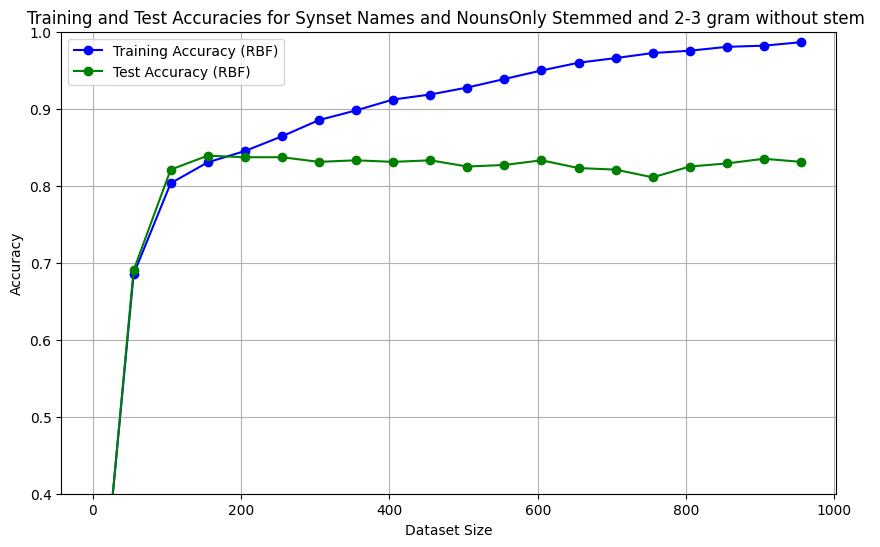

In [188]:
import matplotlib.pyplot as plt

# Updated dataset sizes including points less than 50
dataset_sizes = [i for i in range(5, 1000, 50)]

# Estimated training and test accuracies for the RBF model across these dataset sizes
train_accuracies_rbf = train_accuracies
test_accuracies_rbf = test_accuracies

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, train_accuracies_rbf, marker='o', label='Training Accuracy (RBF)', color='blue')
plt.plot(dataset_sizes, test_accuracies_rbf, marker='o', label='Test Accuracy (RBF)', color='green')

# Customize the plot
plt.title("Training and Test Accuracies for Synset Names and NounsOnly Stemmed and 2-3 gram without stem ")
plt.xlabel("Dataset Size")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)  # Adjust y-axis for better readability
plt.legend()
plt.grid(True)

# Show the plot
plt.show()